In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
%load_ext tensorboard

In [4]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from matplotlib import pyplot
import time
import os
import csv

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
#train_path = 'C:/Users/samay/Documents/Deep_learning/datasets/Celeba/img_align_celeba'

train_path = '../datasets/calf'

input_shape = (1, 128, 128, 1)
batch_size = 64

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = train_data_gen.flow_from_directory(train_path, 
        color_mode='grayscale', target_size=input_shape[1:3], 
        batch_size=batch_size, class_mode=None)

Found 507 images belonging to 2 classes.


In [7]:
train_set.samples

507

In [8]:
504/32

15.75

(64, 128, 128, 1)


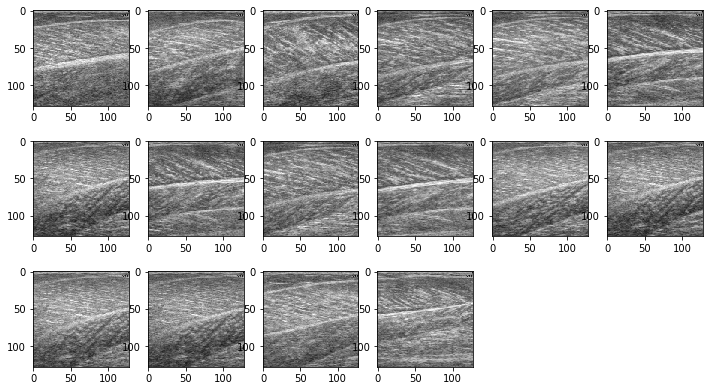

In [9]:
x = next(train_set)
print(x.shape)

import numpy as np
import random


pyplot.figure(figsize=(12,14))


for i in range(16):
    img = x[i]
    img = np.squeeze(img)
    pyplot.subplot(6,6,i+1)
    pyplot.imshow(img, cmap='gray')


In [10]:
# define the standalone discriminator model
def define_discriminator(in_shape=input_shape[1:]):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [11]:
a = define_discriminator()
a.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

In [35]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 256x256
# 	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
# 	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
	return model

In [13]:
a = define_generator(100)
a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)        

In [14]:
generator = define_generator(100)
num_examples_to_generate = 16
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, 100])
#generated_image = generator(noise, training=False)

# print(generated_image.shape)

In [15]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, lr):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=lr, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# select real samples
def generate_real_samples(dataset):
	# choose random instances
# 	ix = randint(0, dataset.samples, n_samples)
	# retrieve selected images
	X_real = next(dataset)
	ix = np.random.randint(0, X_real.shape[0], num_examples_to_generate)
	X_real = X_real[ix]
	X_real = X_real.astype('float32')
	# scale from [0,255] to [-1,1]
	X_real = (X_real - 127.5) / 127.5
	# generate 'real' class labels (1)
	y = ones((X_real.shape[0], 1))
	return X_real, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_sample):
	# generate points in latent space
	x_input = tf.random.normal([n_sample, latent_dim])
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((x_input.shape[0], 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, filename_start, outputPaths, n=4):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	pyplot.figure(figsize=(12,14))
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		examples = (lambda img: np.squeeze(img))(examples)
		pyplot.imshow(examples[i], cmap='gray')
	# save plot to file
	filename = '%s/generated_plot_e%03d.png' % (outputPaths['img'], filename_start+epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, filename_start, outputPaths):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = (g_model.predict(seed), zeros((num_examples_to_generate, 1)))
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	log = '>%.0f%%, %.0f%%' % (acc_real*100, acc_fake*100)
	write_log(f'{outputPaths["logs"]}/acc.csv', log)
	# save plot
	save_plot(x_fake, epoch, filename_start, outputPaths)
	# save the generator model tile file
	g_filename = '%s/generator_model_%03d.h5' % (outputPaths['gen'], filename_start+epoch+1)
	# save the discriminator model tile file
	d_filename = '%s/discriminator_model_%03d.h5' % (outputPaths['dis'], filename_start+epoch+1)
	g_model.save(g_filename)
	d_model.save(d_filename)

In [16]:
def write_log(path, output):
    with open(path,'a') as f:
        writer = csv.writer(f)
        writer.writerow(output.split(','))

In [42]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size, filename_start=0, outputPaths=time.time()):
    n_batch = dataset.samples/batch_size
    # manually enumerate epochs
    for i in range(n_epochs):
        start = time.time()
        # enumerate batches over the training set
        for j in range(0, dataset.samples, batch_size):
            batch_dataset = next(dataset)
            start_j = time.time()
            # get randomly selected 'real' samples
            X_real = batch_dataset.astype('float32')
            # scale from [0,255] to [-1,1]
            X_real = (X_real - 127.5) / 127.5
            y_real = ones((batch_dataset.shape[0], 1))
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_dataset.shape[0])
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = tf.random.normal([batch_size, latent_dim])
            # create inverted labels for the fake samples
            y_gan = ones((batch_size, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('%d/%d, time=%.3f, d1=%.3f, d2=%.3f g=%.3f' %
            (j/batch_size,n_batch, time.time()-start_j, d_loss1, d_loss2, g_loss))
        log = '%d, %.3fs, %.3f, %.3f, %.3f' % (i+1, (time.time()-start), d_loss1, d_loss2, g_loss)
        write_log(f'{outputPaths["logs"]}/log.csv', log)
        print('epoch>%d, time=%.3fs, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, (time.time()-start), d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim, filename_start, outputPaths)

In [48]:
def training_preprocess(n_epochs=300, latent_dim = 100, lr=0.0002):
    n_epochs=n_epochs
    # size of the latent space
    latent_dim = latent_dim
    # create the discriminator
    d_model = define_discriminator()
    # create the generator
    g_model = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model, lr)
    
    return d_model, g_model, gan_model, n_epochs, latent_dim

### Hyperparameter tuning

In [44]:
def outputDir(rootDir):
    dirNames = ['gen','dis','img','logs']
    paths = dict()
    timer = time.time()
    for name in dirNames:
        path = f'output/{timer}_{str(rootDir)}/{name}'
        paths[name] = path
        if not os.path.exists(path):
            os.makedirs(path)
            print("Directory " , path ,  " Created ")
        else:    
            print("Directory " , path ,  " already exists") 
    return paths

In [45]:
# learning_rate = [3e-4,4e-4,5e-4,6e-4,7e-4,8e-4]
learning_rate = [4e-4]
for lr in learning_rate:
    paths = outputDir(lr)
    d_model, g_model, gan_model, n_epochs, latent_dim = training_preprocess(lr=lr)
    train(g_model, d_model, gan_model, train_set, latent_dim, n_epochs, batch_size, outputPaths=paths)

Directory  output/1593701860.2686222_0.0004/gen  Created 
Directory  output/1593701860.2686222_0.0004/dis  Created 
Directory  output/1593701860.2686222_0.0004/img  Created 
Directory  output/1593701860.2686222_0.0004/logs  Created 
0/7, time=2.584, d1=0.691, d2=0.696 g=0.692
1/7, time=0.481, d1=0.670, d2=0.696 g=0.690
2/7, time=0.482, d1=0.630, d2=0.701 g=0.679
3/7, time=0.482, d1=0.530, d2=0.717 g=0.649
4/7, time=0.486, d1=0.329, d2=0.742 g=0.657
5/7, time=0.480, d1=0.111, d2=0.718 g=0.832
6/7, time=0.839, d1=0.030, d2=0.689 g=0.938
7/7, time=0.480, d1=0.013, d2=0.738 g=0.899
epoch>1, time=7.081s, d1=0.013, d2=0.738, g=0.899
0/7, time=0.480, d1=0.020, d2=0.665 g=0.761
1/7, time=0.483, d1=0.020, d2=1.204 g=0.481
2/7, time=0.481, d1=0.086, d2=0.991 g=0.912
3/7, time=0.482, d1=0.344, d2=0.666 g=1.953
4/7, time=0.483, d1=0.383, d2=0.533 g=2.031
5/7, time=0.482, d1=0.177, d2=0.610 g=1.085
6/7, time=0.466, d1=0.069, d2=0.629 g=0.876
7/7, time=0.479, d1=0.028, d2=0.590 g=0.868
epoch>2, time

In [49]:
learning_rate = [4e-4]
for lr in learning_rate:
    paths = outputDir(lr)
    d_model, g_model, gan_model, n_epochs, latent_dim = training_preprocess(lr=lr, n_epochs=400)
    model_no = 600
    path = './output/1593703621.0181172_0.0004/'
    g_model.load_weights(f'{path}/gen/generator_model_{model_no}.h5')
    d_model.load_weights(f'{path}/dis/discriminator_model_{model_no}.h5')
    train(g_model, d_model, gan_model, train_set, latent_dim, n_epochs, batch_size, outputPaths=paths, filename_start=model_no)

Directory  output/1593705751.9451241_0.0004/gen  Created 
Directory  output/1593705751.9451241_0.0004/dis  Created 
Directory  output/1593705751.9451241_0.0004/img  Created 
Directory  output/1593705751.9451241_0.0004/logs  Created 
0/7, time=1.822, d1=0.033, d2=0.515 g=7.718
1/7, time=0.478, d1=0.187, d2=0.076 g=6.935
2/7, time=0.839, d1=0.072, d2=0.132 g=7.340
3/7, time=0.478, d1=0.031, d2=0.008 g=7.777
4/7, time=0.477, d1=0.183, d2=0.124 g=4.904
5/7, time=0.479, d1=0.041, d2=0.269 g=7.529
6/7, time=0.480, d1=0.270, d2=0.091 g=6.492
7/7, time=0.480, d1=0.089, d2=0.158 g=4.890
epoch>1, time=6.304s, d1=0.089, d2=0.158, g=4.890
0/7, time=0.483, d1=0.212, d2=0.067 g=6.468
1/7, time=0.479, d1=0.163, d2=0.104 g=5.805
2/7, time=0.465, d1=0.107, d2=0.219 g=5.298
3/7, time=0.483, d1=0.061, d2=0.113 g=7.737
4/7, time=0.479, d1=0.118, d2=0.061 g=6.320
5/7, time=0.480, d1=0.160, d2=0.213 g=6.199
6/7, time=0.481, d1=0.114, d2=0.112 g=6.532
7/7, time=0.477, d1=0.222, d2=0.024 g=4.792
epoch>2, time

In [ ]:
learning_rate = [1e-3,1e-4,1e-5,1e-6,1e-7]
for lr in learning_rate:
    paths = outputDir(lr)
    d_model, g_model, gan_model, n_epochs, latent_dim = training_preprocess(lr=lr)
    train(g_model, d_model, gan_model, train_set, latent_dim, n_epochs, batch_size, outputPaths=paths)

In [ ]:
real, _ = generate_real_samples(train_set);real.shape

In [ ]:
def samples_plot(samples, revert_back=False):
    samples = (samples + 1) / 2.0
    pyplot.figure(figsize=(12,14))

    for i in range(samples.shape[0]):
        img = samples[i]

        pyplot.subplot(6,6,i+1)
        pyplot.imshow(img)

In [ ]:
samples_plot(real)

In [ ]:
samples, _ = generate_fake_samples(g_model, 100, 8)

In [ ]:
samples.shape

In [ ]:
samples_plot(samples)

In [ ]:
train(g_model, d_model, gan_model, train_set, latent_dim, n_epochs, batch_size, filename_start=model_no)